In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tqdm
import skimage
import pickle as pkl
from scipy import interpolate
from scipy.signal import convolve2d


In [2]:
def show_vector_field(vf, num_arrows = 10, title=""):
    H, W = vf.shape[:2]
    x,y = np.meshgrid(np.arange(0, W, W//num_arrows),np.arange(0, H, H//num_arrows))
    fig, ax = plt.subplots()
    ax.quiver(x, y, vf[y, x, 0], vf[y, x, 1])
    ax.set_title(title)

<IPython.core.display.Javascript object>


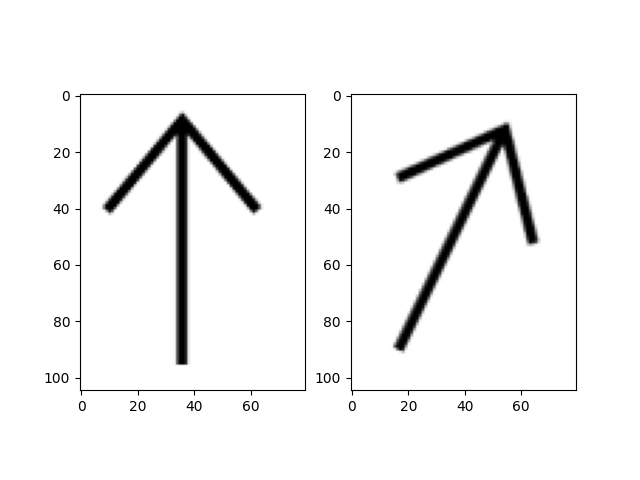

In [3]:
#Load images
# I0  = cv2.cvtColor(cv2.imread("samples/face1.png"), cv2.COLOR_BGR2RGB) / 255.0
# I1  = cv2.cvtColor(cv2.imread("samples/face2.png"), cv2.COLOR_BGR2RGB) / 255.0

I0  = cv2.cvtColor(cv2.imread("samples/arrow0.png"), cv2.COLOR_BGR2RGB) / 255.0
I1  = cv2.cvtColor(cv2.imread("samples/arrow1.png"), cv2.COLOR_BGR2RGB) / 255.0

# I0  = cv2.cvtColor(cv2.imread("samples/Arjun.jpg"), cv2.COLOR_BGR2RGB)[200:1600, 400:1600] / 255.0
# I1  = cv2.cvtColor(cv2.imread("samples/Pranav.jpg"), cv2.COLOR_BGR2RGB)[200:1600, 400:1600] / 255.0
# ratio = 0.15
# I0 = cv2.resize(I0, (int(I0.shape[1]*ratio), int(I0.shape[0]*ratio)))
# I1 = cv2.resize(I1, (int(I1.shape[1]*ratio), int(I1.shape[0]*ratio)))

# If they're not the same size, resize them before padding
# I0 = cv2.copyMakeBorder(I0, 10, 10, 10, 10, cv2.BORDER_CONSTANT)
# I1 = cv2.copyMakeBorder(I1, 10, 10, 10, 10, cv2.BORDER_CONSTANT)
%matplotlib notebook
fig, ax = plt.subplots(1, 2)
ax[0].imshow(I0)
ax[1].imshow(I1)


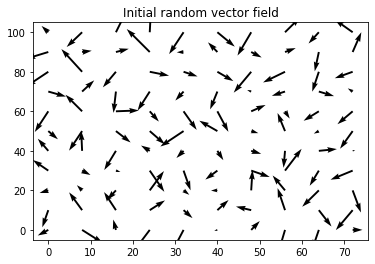

In [141]:
H, W = I0.shape[:2]
half_vf = (np.random.rand(H, W, 2)-0.5)*5
# half_vf = np.zeros((H, W, 2))
show_vector_field(half_vf, title="Initial random vector field")


In [5]:
def phi0(v):
    # Map from halfway domain to I0
    H, W = v.shape[:2]
    x, y = np.meshgrid(np.arange(0, W, 1),np.arange(0, H, 1))
    map0 = np.zeros((H, W, 2))
    map0[y, x, 0] = x
    map0[y, x, 1] = y
#     fig, ax = plt.subplots(1, 2)
#     ax[0].imshow(map0[:, :, 0])
#     ax[1].imshow(map0[:, :, 1])
    map0 -= v
#     fig, ax = plt.subplots(1, 2)
#     ax[0].imshow(map0[:, :, 0])
#     ax[1].imshow(map0[:, :, 1])
    return map0

def phi1(v):
    # Map from halfway domain to I1
    H, W = v.shape[:2]
    x, y = np.meshgrid(np.arange(0, W, 1),np.arange(0, H, 1))
    map1 = np.zeros((H, W, 2))
    map1[y, x, 0] = x
    map1[y, x, 1] = y
#     fig, ax = plt.subplots(1, 2)
#     ax[0].imshow(map1[:, :, 0])
#     ax[1].imshow(map1[:, :, 1])
    map1 += v
#     fig, ax = plt.subplots(1, 2)
#     ax[0].imshow(map1[:, :, 0])
#     ax[1].imshow(map1[:, :, 1])
    return map1

def bilinear_interpolate_single(img, x, y):
    x1, x2, y1, y2 = int(x), int(x+1), int(y), int(y+1)
    
    x_left = 1 - (x - x1)
    x_right = 1 - x_left
    
    y_top = 1 - (y2 - y)
    y_bottom = 1 - y_top
    x1 = np.clip(int(x), 0, img.shape[1]-1)
    x2 = np.clip(int(x+1), 0, img.shape[1]-1)
    y1 = np.clip(int(y), 0, img.shape[0]-1)
    y2 = np.clip(int(y+1), 0, img.shape[0]-1)
    
    x_res = img[y1, x1]*x_left + img[y1, x2]*x_right
    x1_res = img[y2, x1]*x_left + img[y2, x2]*x_right

    res = x1_res*y_top + x_res*y_bottom
    return res

def bilinear_interpolate(img, xs, ys):
    # Return an array with interpolated img values of length=len(x)=len(y)
#     xs.clip(0, img.shape[1]-2, out=xs)
#     ys.clip(0, img.shape[0]-2, out=ys)
    result = []
    for x, y in zip(xs, ys):
        x1, x2, y1, y2 = int(x), int(x+1), int(y), int(y+1)
    
        x_left = 1 - (x - x1)
        x_right = 1 - x_left

        y_top = 1 - (y2 - y)
        y_bottom = 1 - y_top
#         x1 = np.clip(int(x), 0, img.shape[1]-1)
#         x2 = np.clip(int(x+1), 0, img.shape[1]-1)
#         y1 = np.clip(int(y), 0, img.shape[0]-1)
#         y2 = np.clip(int(y+1), 0, img.shape[0]-1)

        x_res = img[y1, x1]*x_left + img[y1, x2]*x_right
        x1_res = img[y2, x1]*x_left + img[y2, x2]*x_right

        result.append(x1_res*y_top + x_res*y_bottom)
    return np.array(result)
    
    
def N(y, x, H, W, size=5):
    # Get a neighbourhood around point (x, y) of size 5. Size must be odd
#     xs = np.clip(np.arange(x-size//2, x+size//2+1), 0, W-1)
#     ys = np.clip(np.arange(y-size//2, y+size//2+1), 0, H-1)
    xs = np.arange(x-size//2, x+size//2+1)
    ys = np.arange(y-size//2, y+size//2+1)
    return ys, xs


# m0 = phi0(half_vf)
# m1 = phi1(half_vf)
# fig, ax = plt.subplots(1, 2)
# ax[0].imshow((m0+m1)[:, :, 0])
# ax[1].imshow((m0+m1)[:, :, 1])

In [6]:
def SIM(p0, p1):
    m0 = np.mean(p0, axis=0)
    m1 = np.mean(p1, axis=0)

    N = p0.shape[0]
    s0 = (np.sum((p0-m0)**2)/(N-1))**0.5
    s1 = (np.sum((p1-m1)**2)/(N-1))**0.5
    s01 = np.sum((p0-m0)*(p1-m1))/(N-1)
    
    C2 = 58.5
    C3 = 29.3
    c = (2*s0*s1 + C2)/(s0**2 + s1**2 + C2)
    s = (np.abs(s01) + C3)/(s0*s1 + C3)
    
    return c*s

def similarity_energy(v, I0, I1, padding=0, size=5):
    # Returns grid with similarity energy values for all (x, y) points
    # Padding must be >= size//2
    energy = np.zeros(v.shape[:2])
    H, W = v.shape[:2]
    map0 = phi0(v) # (H, W, 2)
    map1 = phi1(v)
    map0[..., 0] = np.clip(map0[..., 0], 0, W-2)
    map0[..., 1] = np.clip(map0[..., 1], 0, H-2)
    map1[..., 0] = np.clip(map1[..., 0], 0, W-2)
    map1[..., 1] = np.clip(map1[..., 1], 0, H-2)
    
#     pbar = tqdm.tqdm_notebook(total=v.shape[0])
    for y in range(2, v.shape[0]-2):
        for x in range(2, v.shape[1]-2):
            ys, xs = N(y, x, H, W, size)
            yy, xx = np.meshgrid(ys, xs)
#             print(x, y)
#             print(map0.shape)
#             print(neighbors)
#             print(map0[yy, xx].shape)
            N0 = bilinear_interpolate(I0, map0[yy, xx][..., 0].reshape(-1), map0[yy, xx][..., 1].reshape(-1))
            N1 = bilinear_interpolate(I1, map1[yy, xx][..., 0].reshape(-1), map1[yy, xx][..., 1].reshape(-1))
        
#             print(N0.shape)

            energy[y, x] = 1-SIM(N0, N1)

#         pbar.update(1)
        
    return energy

# %matplotlib notebook
# e = similarity_energy(half_vf, I0, I1)
# print(e.sum())
# fig, ax = plt.subplots()
# # ax.imshow(e[2:-2, 2:-2])
# ax.imshow(e)


(105, 80) 105 80


<IPython.core.display.Javascript object>


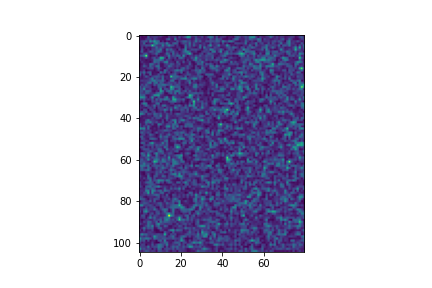

437474.1412289205


In [79]:
def TPS(grid):
    dx2_k = np.array([[0, 0, 0],
                    [1, -2, 1], 
                    [0, 0, 0]])
    
    dy2_k = np.array([[0, 1, 0],
                    [0, -2, 0], 
                    [0, 1, 0]])
    
    dxdy_k = np.array([[1, -1],
                    [-1, 1]])/4
    
    dx2 = convolve2d(grid, dx2_k, mode='same')
    dy2 = convolve2d(grid, dy2_k, mode='same')
    dxdy = convolve2d(grid, dxdy_k, mode='same')
    
    return dx2**2 + dy2**2 + 2*dxdy**2

def smoothness_energy(v):
    # Returns grid with smoothness energy values for all (x, y) points
    return TPS(v[:, :, 0]) + TPS(v[:, :, 1])

e = smoothness_energy(half_vf)
print(e.shape, H, W)
fig, ax = plt.subplots()
ax.imshow(e)
print(e.sum())

<IPython.core.display.Javascript object>


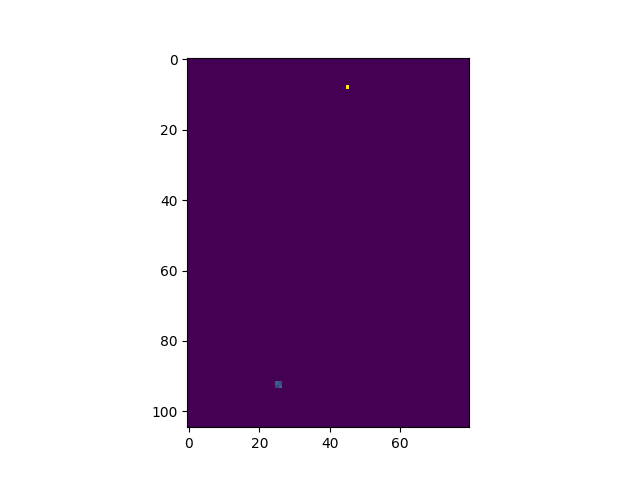

In [8]:
def ui_energy(v, p0, p1):
    H, W = v.shape[:2]
    
    u = (p0+p1)/2
    vu = (p1-p0)/2
    energy = np.zeros(v.shape[:2])
    for i in range(vu.shape[0]):
        x, y = u[i]
        points = np.array([(int(x), int(y)), 
                  (int(x), int(y+1)), 
                  (int(x+1), int(y+1)), 
                  (int(x+1), int(y))])
        d = np.array([np.linalg.norm(v[points[0, 1], points[0, 0]] - vu[i])**2, 
                      np.linalg.norm(v[points[1, 1], points[1, 0]] - vu[i])**2, 
                      np.linalg.norm(v[points[2, 1], points[2, 0]] - vu[i])**2, 
                      np.linalg.norm(v[points[3, 1], points[3, 0]] - vu[i])**2])
                      
        
        weights = np.clip(1 - np.linalg.norm(np.ones(points.shape)*u[i] - points, axis=1), 0, 1)
        if sum(weights) != 1:
            weights[:] = 0.25
        energy_4 = weights*d
        for i, p in enumerate(points):
            energy[p[1], p[0]] += energy_4[i]
    energy /= (W*H)
    return energy

# P0, P1 = np.array([[0, 0], [4, 0], [22, 46]]), np.array([[0, 4], [4, 8], [22, 51]])
# P0, P1 = np.array([[0, 0]]), np.array([[0, 0]])
P0, P1 = np.array([[35, 6], [35, 95]]), np.array([[55, 10], [16, 90]])
# P0, P1 = np.array([[7, 18], [7, 2]]), np.array([[3, 17], [10, 3]])
# P0, P1 = np.array([[5, 1], [5, 13]]), np.array([[8, 2], [2, 12]])
ui = ui_energy(half_vf, P0, P1)
fig, ax = plt.subplots()
ax.imshow(ui)

In [142]:
def E(v, I0, I1, P0, P1,lmbda = 0.001, gamma=100, include_sim=True):
    
#     return np.linalg.norm(v-np.ones(v.shape))
    return sum(E_separate(v, I0, I1, P0, P1, lmbda=lmbda, gamma=gamma, include_sim=include_sim))
  

def E_separate(v, I0, I1, P0, P1,lmbda = 0.001, gamma=100, include_sim=True):
    if not include_sim:
        return np.zeros(v.shape[:2]), lmbda*smoothness_energy(v),  gamma*ui_energy(v, P0, P1)
    
    if max(v.shape[:2]) < 50:
        sim = similarity_energy(v, I0, I1)
    else:
        sim = np.zeros(v.shape[:2])
        box_size = 5
        i_skip = v.shape[0]//box_size
        j_skip = v.shape[1]//box_size
        for i in range(box_size):
            for j in range(box_size):
                i1 = max(0, i*i_skip-2)
                i2 = (i+1)*i_skip+2
                j1 = max(0, j*j_skip-2)
                j2 = (j+1)*j_skip+2
                sim[i1:i2, j1:j2][2:-2, 2:-2] = similarity_energy(v[i1:i2, j1:j2],
                                                      I0[i1:i2, j1:j2],
                                                      I1[i1:i2, j1:j2])[2:-2, 2:-2]      
        
    return sim, lmbda*smoothness_energy(v), gamma*ui_energy(v, P0, P1)

# %matplotlib inline
# sim, tps, ui = E_separate(half_vf, I0, I1, P0, P1)
# fig, ax = plt.subplots(1, 3)
# ax[0].imshow(sim)
# ax[1].imshow(tps)
# ax[2].imshow(ui)
# print((sim+tps+ui).sum())

In [143]:
def get_pyramids(v, I0, I1, P0, P1, depth=4, ratio=0.6):
    pyramids = [{'P0':P0, 'P1':P1, 'I0':I0, 'I1':I1}]
    
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(I0)
    ax[1].imshow(I1)
    ax[0].plot(P0[:, 0], P0[:, 1], 'ro')
    ax[1].plot(P1[:, 0], P1[:, 1], 'ro')
    
    for i in range(depth):
        pyramid = {}
        
        P0, P1 = (P0*ratio).astype(int), (P1*ratio).astype(int)
        pyramid['P0'] = P0
        pyramid['P1'] = P1
        
        H, W = I0.shape[:2]
        I0 = cv2.resize(I0, (int(W*ratio), int(H*ratio)))
        I1 = cv2.resize(I1, (int(W*ratio), int(H*ratio)))
        pyramid['I0'] = I0
        pyramid['I1'] = I1
        
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(I0)
        ax[1].imshow(I1)
        ax[0].plot(P0[:, 0], P0[:, 1], 'ro')
        ax[1].plot(P1[:, 0], P1[:, 1], 'ro')
        pyramids.append(pyramid)
        
        
    return pyramids

        
        
# %matplotlib inline        
# pyramids = get_pyramids(half_vf,I0, I1, P0, P1)    
    
    
    

<IPython.core.display.Javascript object>


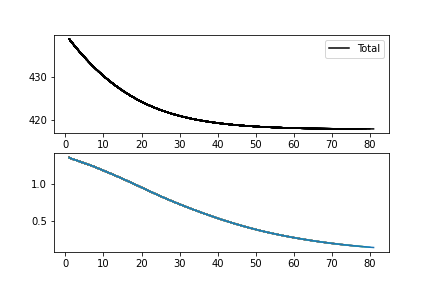

Error increasing, breaking


In [161]:
def dEdv(v, I0, I1, P0, P1, Ev, lmbda=0.001, gamma=100, eps=0.01, include_sim=True):
    H, W = v.shape[:2]
    dvx = np.ones(v.shape)*eps
    dvx[:, :, 1] = 0
    gradx = (E(v+dvx, I0, I1, P0, P1, lmbda=lmbda, gamma=gamma, include_sim=include_sim) - Ev)/eps
    
    dvy = np.ones(v.shape)*eps
    dvy[:, :, 0] = 0
    grady = (E(v+dvy, I0, I1, P0, P1, lmbda=lmbda, gamma=gamma, include_sim=include_sim) - Ev)/eps
    
    gradient = np.dstack((gradx, grady))
    return gradient

def optimize(v, I0, I1, P0, P1, epochs=2000, eta=10, include_sim = True):
    '''
    Arguments: Initial halfway vector field
               Correspondence points P0 and P1 from I0 and I1
               Epcohs to run gradient descent
               Learning rate eta
                
    Return: v(Optimized vector field)
    '''
    %matplotlib notebook
    fig, ax = plt.subplots(2, 1)
    xs = []
    errors = []
    errort = []
    erroru = []
    error_total = []
    diffs = []
    
    lmbda=0.001
    gamma=100

    b1 = 0.9
    b2 = 0.999
    alpha = 0.05
    
    m1 = 0
    m2 = 0
    prev_error1 = 1e6
    prev_error2 = 3e6
    for it in range(1, epochs+1):
        try:
            old_v = v.copy()

            Esim, Etps, Eui = E_separate(v, I0, I1, P0, P1, lmbda=lmbda, gamma=gamma, include_sim=include_sim)
            Ev = Esim + Etps + Eui
            gradient = dEdv(v, I0, I1, P0, P1, Ev, lmbda=lmbda, gamma=gamma, include_sim=include_sim)

            m1 = b1*m1 + (1-b1)*gradient
            m2 = b2*m2 + (1-b2)*(gradient**2)

            m1_ = m1 / (1-b1**it)
            m2_ = m2 / (1-b2**it)

            update = alpha*m1_/(m2_**0.5 + 1e-9)
#             update = alpha*gradient
    
            update_norm = np.linalg.norm(update)
            v = v - update

            total_error = Ev.sum()
#             print(f"Epoch {it}:", update_norm, total_error)

            xs.append(it)
            errors.append(Esim.sum())
            errort.append(Etps.sum())
            erroru.append(Eui.sum())
            error_total.append(errors[-1]+errort[-1]+erroru[-1])
            diffs.append(update_norm)


#             ax[0].plot(xs, errors, 'red', label='SIM')
#             ax[0].plot(xs, errort, 'blue',  label='TPS')
#             ax[0].plot(xs, erroru, 'green',  label='UI')
            ax[0].plot(xs, error_total, 'black', label='Total')
            if it == 1:
                ax[0].legend()
            
            ax[1].plot(xs, diffs)
            fig.canvas.draw()

            if total_error < 1e-3 or update_norm < 1e-6:
                print("Converged")
                break

            
            if error_total[-1] > prev_error1:
                print("Error increasing, breaking")
                v + v + update
                break
                
            prev_error2 = prev_error1
            prev_error1 = error_total[-1]
            
        except IOError:
            pass
        except KeyboardInterrupt:
            break
    return v


# P0, P1 = np.array([[35, 6], [35, 95]]), np.array([[55, 10], [16, 90]])
# P0, P1 = np.array([[7, 18], [7, 2]]), np.array([[3, 17], [10, 3]])
# P0, P1 = np.array([[5, 1], [5, 13]]), np.array([[8, 2], [2, 12]])
# lim = 100
# print(optimize(half_vf[:lim, :lim, :], I0[:lim, :lim, :], I1[:lim, :lim, :], P0, P1))   
# half_vf = np.ones(half_vf.shape)
pyramid = pyramids[-1]
optimized_v = optimize(half_vf, I0, I1, P0, P1, include_sim=False)
# optimized_v_1 = optimize(optimized_v, I0, I1, P0, P1)      
# optimized_v2 = optimize(optimized_v_1, I0, I1, P0, P1)      


<IPython.core.display.Javascript object>


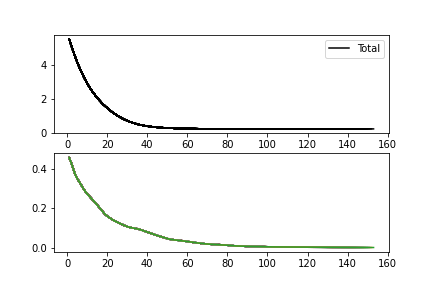

Error increasing, breaking


<IPython.core.display.Javascript object>


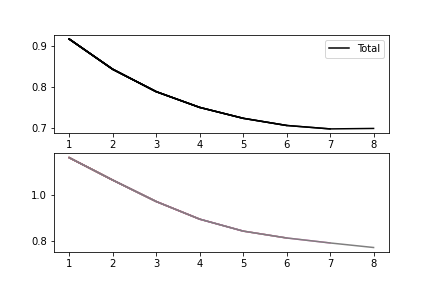

Error increasing, breaking


<IPython.core.display.Javascript object>


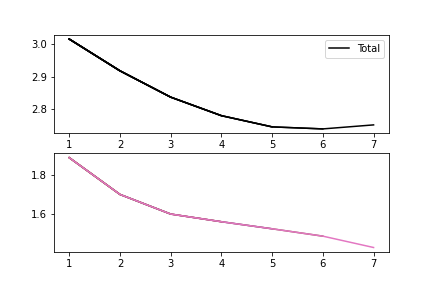

Error increasing, breaking


<IPython.core.display.Javascript object>


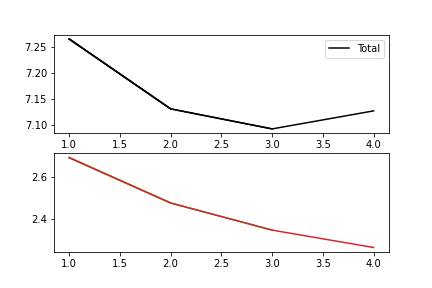

Error increasing, breaking


<IPython.core.display.Javascript object>


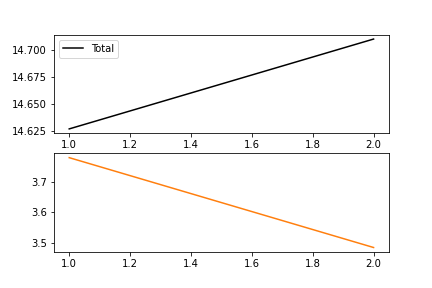

Error increasing, breaking


In [162]:
optimized_vs = []
for i, pyramid in enumerate(pyramids[::-1]):
    if i == 0:
        H, W = pyramid['I0'].shape[:2]
#         starting_vf = np.zeros((H, W, 2))
        starting_vf = np.random.rand(H, W, 2)
        optimized_vf = optimize(starting_vf, pyramid['I0'], pyramid['I1'], pyramid['P0'], pyramid['P1'], include_sim=False)
        optimized_vs.append(optimized_vf)
    else:
        H, W = pyramid['I0'].shape[:2]
        starting_vf = np.dstack((cv2.resize(optimized_vf[:, :, 0], (W, H)), cv2.resize(optimized_vf[:, :, 1], (W, H))))
#         print(starting_vf)
        optimized_vf = optimize(starting_vf, pyramid['I0'], pyramid['I1'], pyramid['P0'], pyramid['P1'], include_sim=True)
        optimized_vs.append(optimized_vf)
    pkl.dump(optimized_vs, open('optimized_vs.pkl', 'wb'))
           
        
    

<IPython.core.display.Javascript object>


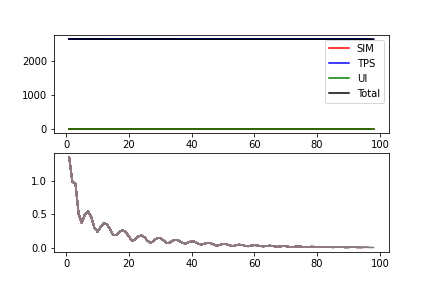

In [100]:
# np.save('optimized_vf_Arjun-Pranav2.npy', optimized_v)
# %matplotlib inline
# print(optimized_vs[-1][8, 45])
# print(optimized_vs[-1][92, 25])
# show_vector_field(optimized_v)
# print(optimized_v.min(), optimized_v.max())

# Er = E(half_vf, I0, I1, P0, P1)
# Ev = E(optimized_v, I0, I1, P0, P1)
# gradient = dEdv(optimized_v, I0, I1, P0, P1, Ev)
# gradient_old = dEdv(half_vf, I0, I1, P0, P1, Er)

# print(Er.sum())
# print(Ev.sum())
# fig, ax = plt.subplots(1, 4)
# ax[0].imshow(Ev)
# ax[1].imshow(gradient[..., 0])
# ax[2].imshow(gradient_old[..., 1])
# ax[3].imshow(Er)

# sim, tps, ui = E_separate(optimized_v, I0, I1, P0, P1)
# fig, ax = plt.subplots(1, 3)
# ax[0].imshow(sim)
# ax[1].imshow(tps)
# ax[2].imshow(ui)

# pyramid = pyramids[0]
# optimized_vf = optimize(optimized_vs[-1], pyramid['I0'], pyramid['I1'], pyramid['P0'], pyramid['P1'], include_sim=False)

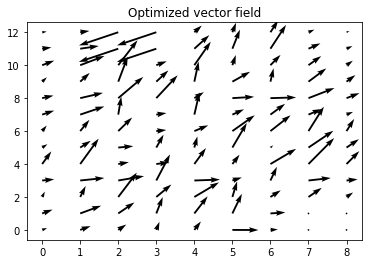

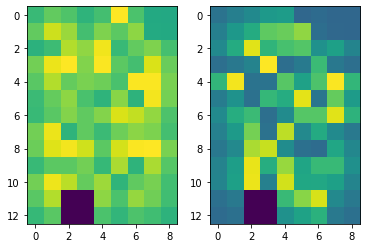

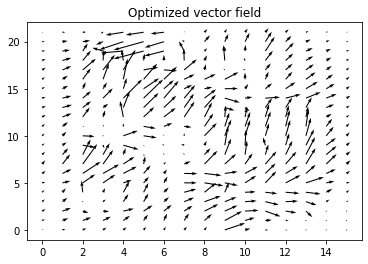

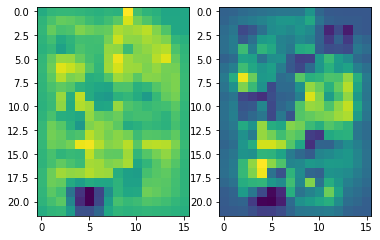

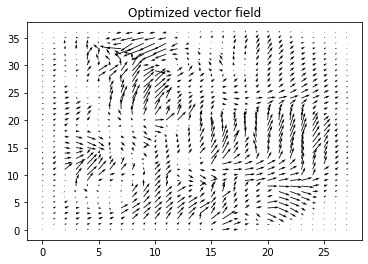

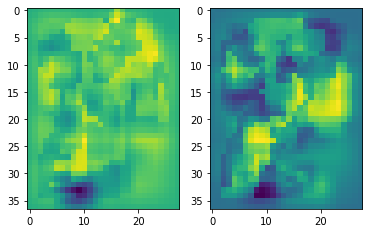

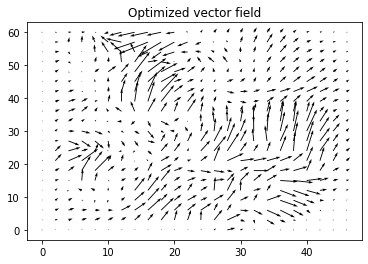

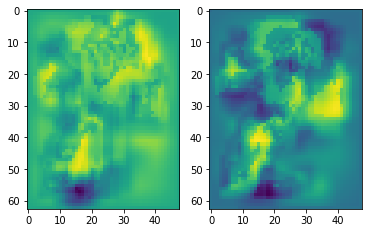

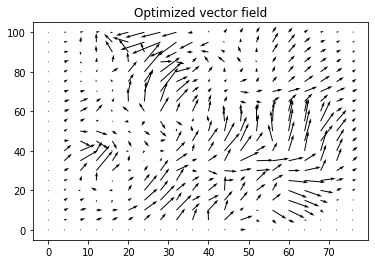

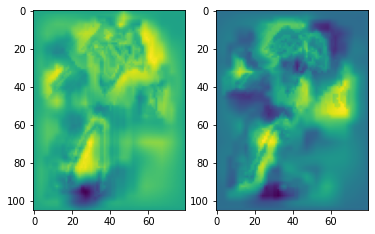

In [163]:
%matplotlib inline
for v in optimized_vs:
    show_vector_field(v, num_arrows=min(20, min(v.shape[:2])), title="Optimized vector field")
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(v[:, :, 0])
    ax[1].imshow(v[:, :, 1])
#     print(v.min(), v.max())


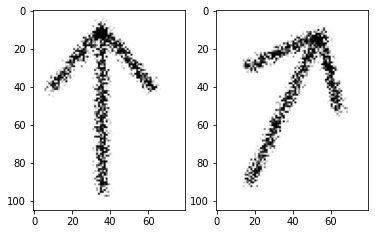

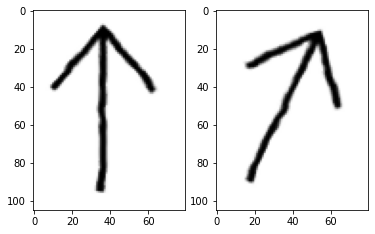

In [164]:
def linear_morph(v, I0, I1):
    H, W = v.shape[:2]
    map0 = phi0(v) # (H, W, 2)
    map1 = phi1(v)
    map0[..., 0] = np.clip(map0[..., 0], 0, W-2)
    map0[..., 1] = np.clip(map0[..., 1], 0, H-2)
    map1[..., 0] = np.clip(map1[..., 0], 0, W-2)
    map1[..., 1] = np.clip(map1[..., 1], 0, H-2)

    im0 = bilinear_interpolate(I0, map0[:, :, 0].reshape(-1), map0[:, :, 1].reshape(-1)).reshape(H, W, 3)
    im1 = bilinear_interpolate(I1, map1[:, :, 0].reshape(-1), map1[:, :, 1].reshape(-1)).reshape(H, W, 3)
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(im0)
    ax[1].imshow(im1)
    return
    
    for a in np.arange(0, 1.1, 0.5):
        #qα=p+(2α−1)v(p).
        frame = np.zeros((H, W, 3))
        for i in range(H):
            for j in range(W):
                qa = np.array([j, i]) 
                p = qa
                vp = v[p[1], p[0]]
                it = 0
                while it < 50:
                    it += 1
                    p_new = (qa - (2*a - 1)*vp)
                    vp_new = bilinear_interpolate_single(v, p_new[1], p_new[0])
                    vp = 0.8*vp_new + (1-0.8)*vp
                    diff = np.linalg.norm(p_new-p)
                    p = p_new
                    if diff < 1e-6:
                        break
                p = p.astype(int)
                frame[i, j] = (1-a)*im0[p[1], p[0]] + a*im1[p[1], p[0]]
                
        
        fig, ax = plt.subplots()
        ax.imshow(frame)
        print(a)



# optimized_v = np.load('optimized_vf_Arjun-Pranav2.npy')
%matplotlib inline
linear_morph(half_vf, I0, I1)
# for i, pyramid in enumerate(pyramids):
#     linear_morph(optimized_vs[i], pyramid['I0'], pyramid['I1'])
linear_morph(optimized_vs[-1], I0, I1)

# fig, ax = plt.subplots(2, 1)
# ax[0].imshow(half_vf[:, :, 0], aspect='auto')
# ax[1].imshow(half_vf[:, :, 1], aspect='auto')
# fig, ax = plt.subplots(2, 1)
# ax[0].imshow(optimized_v[:, :, 0], aspect='auto')
# ax[1].imshow(optimized_v[:, :, 1], aspect='auto')
